In [1]:
# Basic python import
import os
import sys
import yaml
import matplotlib.pyplot as plt
import pandas as pd

# Pytorch
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn

# Our custom module
sys.path.append('../')
import data_processing
import models
import evaluation as eval
import submission as sub

# Config

Ma proposition : 
Avoir un Notebook template associé à des paramètres par défaut. 
Ensuite pour chaque expérience on le duplique, et on change les valeurs des paramètres que l'on souhaite.

In [2]:
with open('../configs/default_params.yaml') as default_params_file:
      default_params = yaml.safe_load(default_params_file)
params = default_params
params

data_dir = os.path.join('..','data')

torch.manual_seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

In [3]:
# Changer de paramètres
params["train"]["batch_size"] = 2
params["train"]

{'script_path': '../train/A_COMPLETER.py',
 'batch_size': 2,
 'epochs': 1000,
 'data_augmentation': {'samplewise_center': False,
  'samplewise_std_normalization': False,
  'rotation_range': 0,
  'width_shift_range': 0.1,
  'height_shift_range': 0.1,
  'horizontal_flip': True,
  'vertical_flip': False,
  'zoom_range': 0,
  'shear_range': 0,
  'channel_shift_range': 0,
  'featurewise_center': False,
  'zca_whitening': False}}

# If necessary, pre-process raw data

In [4]:
from data_processing.preproc import create_masks_as_tiff, preprocess_images_and_masks

#create_masks_as_tiff(data_dir)


# Create Dataset and Dataloader

In [5]:
from data_processing.dataset import CustomDataset
import torchvision.transforms as transforms

transform = transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((512,512))
])

train_dataset = CustomDataset(root_dir = os.path.join('..','data'), transform=transform)

train_dl = DataLoader(train_dataset, batch_size=params["train"]["batch_size"], shuffle=True)

In [6]:
print(train_dataset[0][0].shape)

torch.Size([3, 512, 512])


# Train

In [7]:
from models.unet import UNet

MODEL = UNet(num_classes=1)
lr = 1e-3
optimizer = optim.Adam(MODEL.parameters(), lr=lr)
loss = nn.MSELoss()
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [8]:
from train.train import main_train, main_train_batch1

loss_list = main_train_batch1(model=MODEL.to(device), loss_fn=loss, optimizer=optimizer, n_epochs=25, dataset=train_dataset, device=device)

  0%|          | 0/351 [00:00<?, ?it/s]d:\Logiciels\anaconda\envs\ML3A\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1, 512, 512])) that is different to the input size (torch.Size([1, 1, 512, 512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  8%|▊         | 29/351 [01:03<11:44,  2.19s/it] 


KeyboardInterrupt: 

In [10]:
plt.plot(loss_list)
plt.title("Loss")
plt.xlabel("Epoch")

NameError: name 'loss_list' is not defined

torch.Size([3, 512, 512])
torch.Size([1, 512, 512])


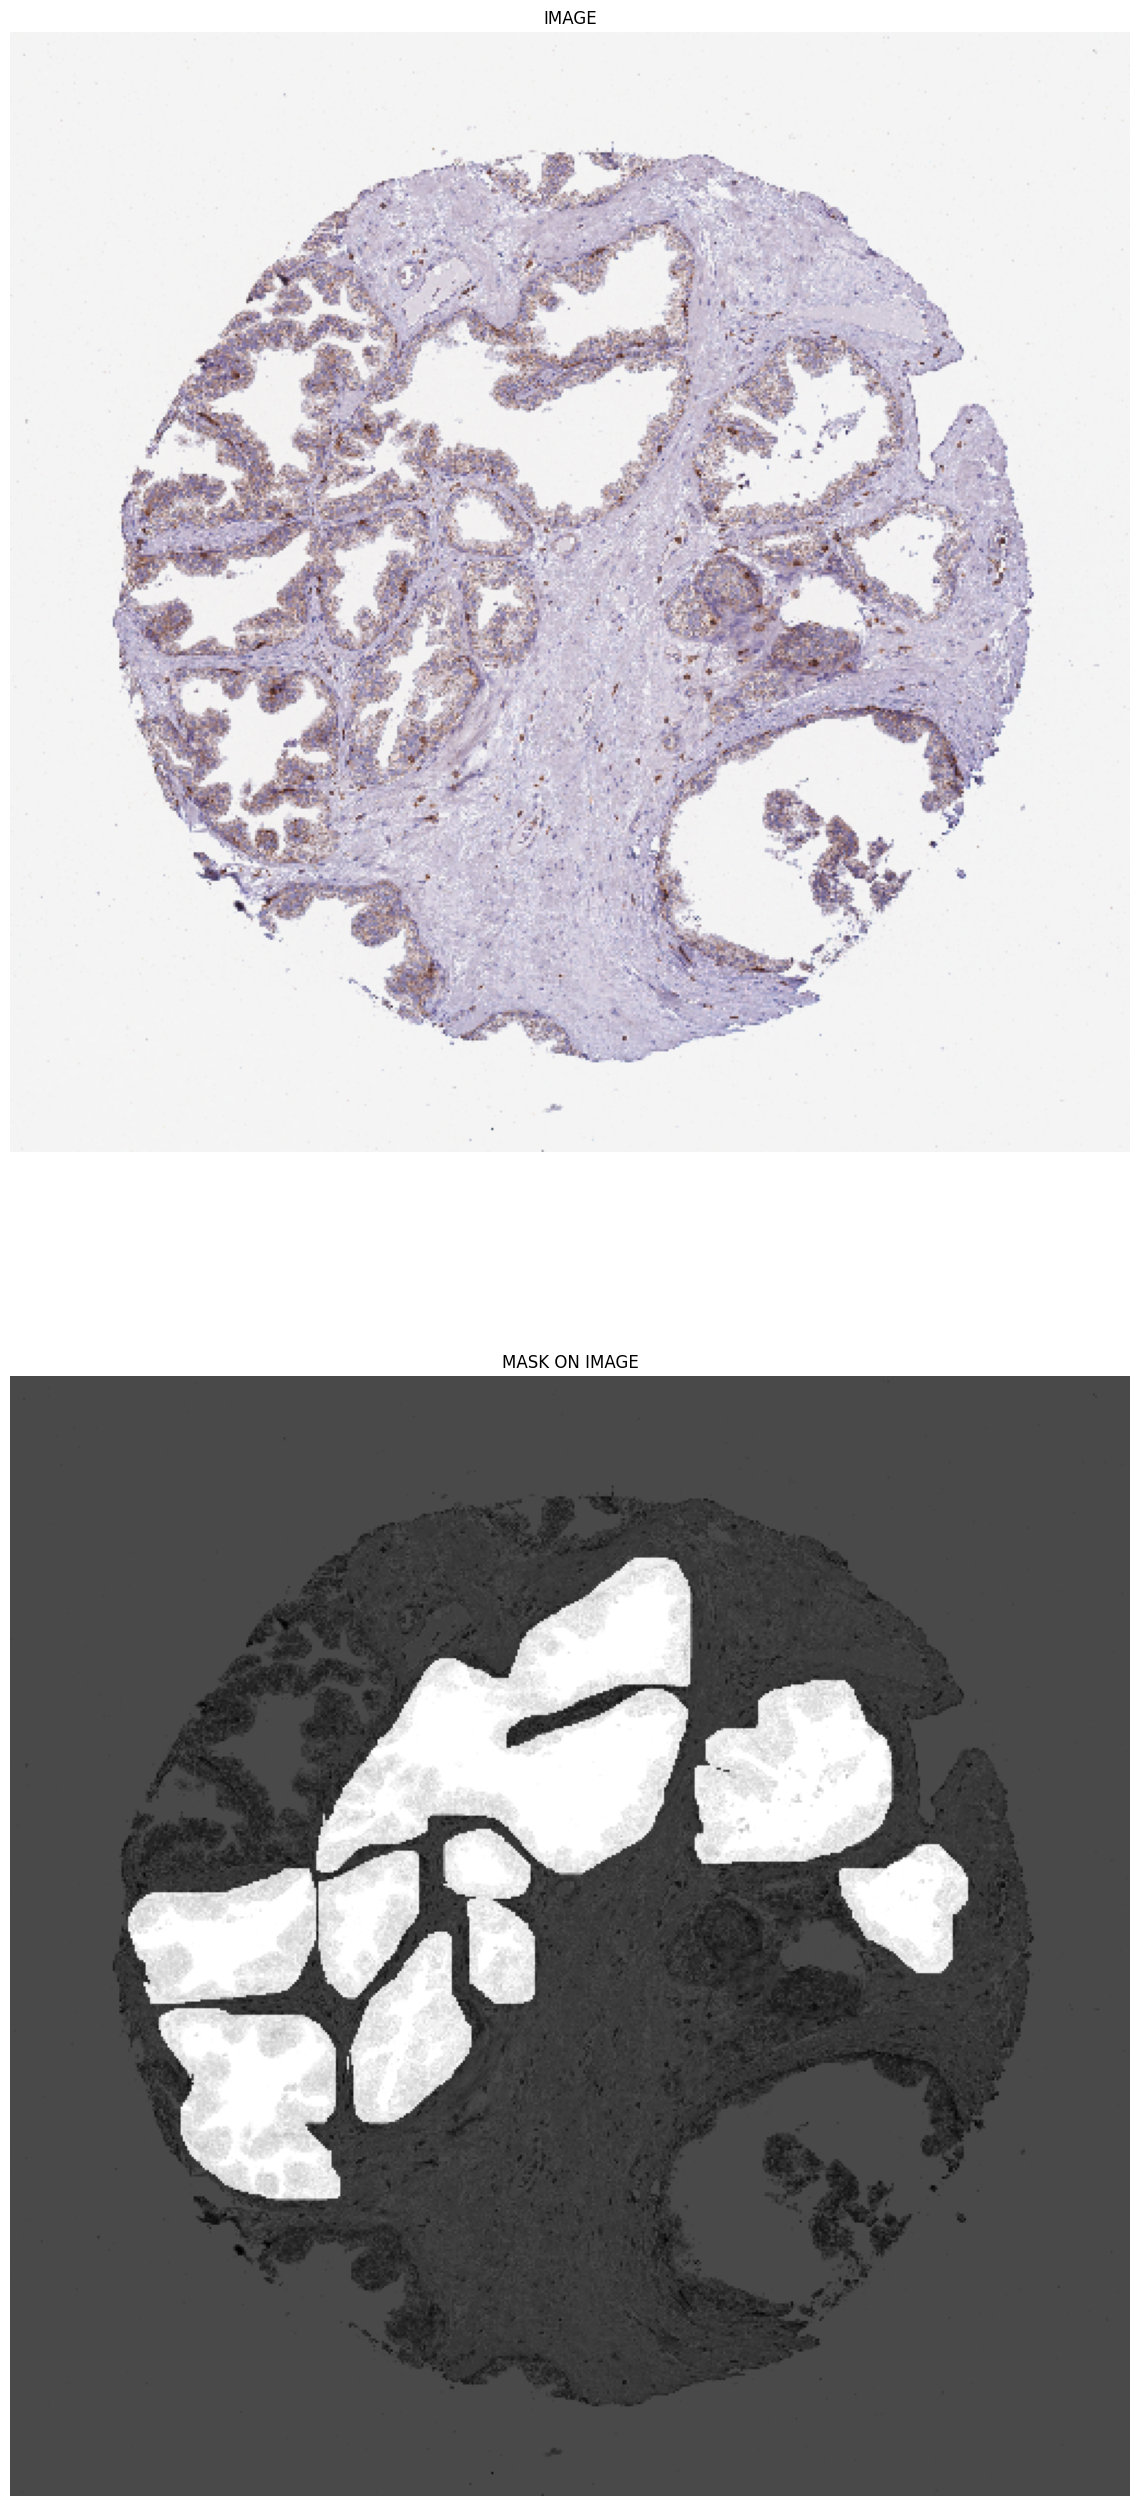

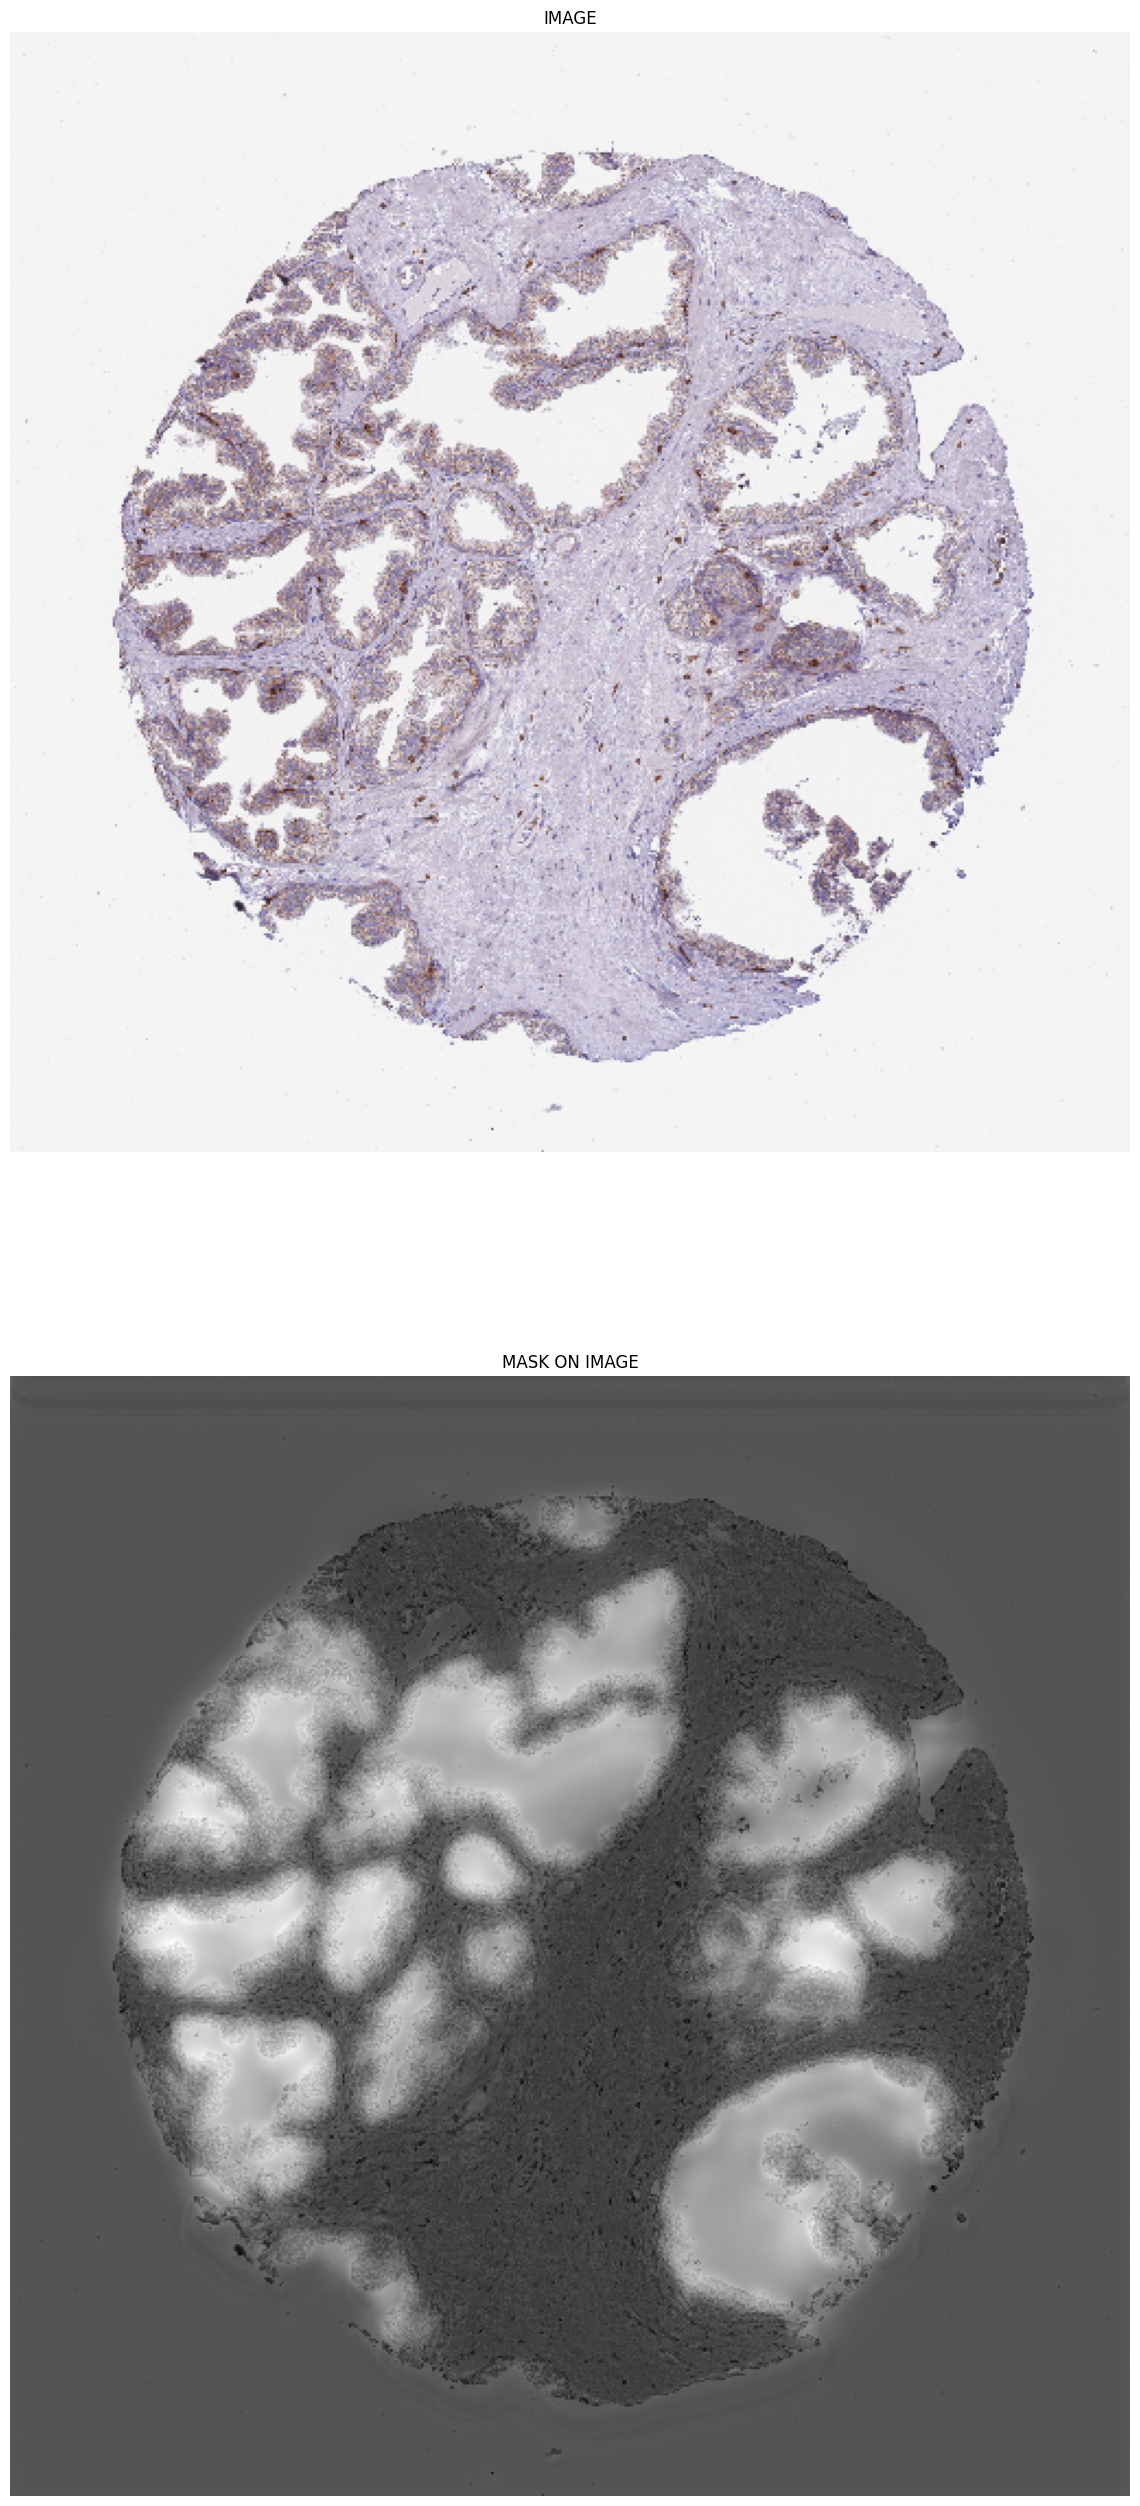

In [30]:
import numpy as np

def show_image_and_mask(image,mask,cmaps):
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 32))
    hybr = image[0, :, :]/2 + mask[0, :, :]

    ax[0].imshow(image.T)
    ax[0].axis('off')
    ax[0].set_title('IMAGE')
    ax[1].imshow(hybr.T,cmap=cmaps)
    ax[1].axis('off')
    ax[1].set_title('MASK ON IMAGE')
    plt.show()

image = train_dataset[0][0]
mask = train_dataset[0][2]

print(image.shape)
print(mask.shape)

show_image_and_mask(image,mask,"gray")
show_image_and_mask(image,MODEL(torch.unsqueeze(image, dim=0).to(device)).cpu().detach(),"gray")

# Evaluation

Running model on validation dataset

In [11]:
val_pred = {"val_images":[], "val_masks":[], "val_organs":[], "val_y_preds":[]}
for k, X in enumerate(train_dl):
    for val_image, val_organ, val_mask in X :
        val_pred['val_images'].append(val_image)
        val_pred['val_mask'].append(val_mask)
        val_pred['val_organ'].append(val_organ)
        pred = MODEL(val_image)
        val_pred['val_y_preds'].append(pred)

ValueError: not enough values to unpack (expected 3, got 2)

In [13]:
train_dataset[0]

3

In [ ]:
IoUs, IoUsOrgans = eval.get_y_true_y_pred(val_pred)

# Plot results for different threshold on all training and get best threshold
best_threshold = eval.plot_iou_by_threshold(IoUs, 'test')

We can also look at some of the results

In [ ]:
eval.plot_validation_predictions(val_pred, best_threshold, 10)

# Submission

In [ ]:
import submission as sub

test_dataset = None
sub.make_submission(MODEL, test_dataset, best_threshold)